# Bank Marketing - Classification Models Comparison  
Samantha Acosta Valdez

---

**Overview:**

This project reproduces a study based on the Bank Marketing dataset from the UCI Machine Learning Repository. The objective is to predict whether a bank client will subscribe to a term deposit after a marketing campaign. The dataset was originally analyzed in the research paper by Moro, Cortez, and Rita (2014), A Data-Driven Approach to Predict the Success of Bank Telemarketing, published in Expert Systems with Applications.

Two classification algorithms covered in class, Logistic Regression and Decision Tree, are applied to replicate the methodology described in the study and to evaluate their performance on the same dataset.

Dataset: https://archive-beta.ics.uci.edu/dataset/222/bank%2Bmarketing?utm_source=chatgpt.com

### ↠ Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from statistics import mean
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn import tree

### ↠ Load Dataset

In [2]:
data = pd.read_csv('bank-full.csv', sep=';')
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


### ↠ Data Cleaning and Preparation

#### ↬ Drop 'duration' → According to UCI this column causes target leakage

In [3]:
if 'duration' in data.columns:
    data = data.drop('duration', axis=1)

#### ↬ Encode target column → 'y': yes = 1, no = 0

In [4]:
data['y'] = (data['y'].str.lower() == 'yes').astype(int)

#### ↬ Display class balance
To know the proportion of positive (1) and negative (0) cases that helps understand the dataset's imbalance and guides modeling decisions.

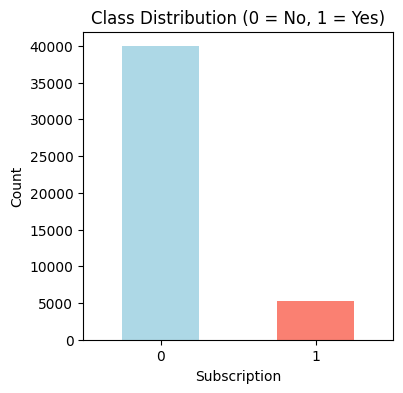

In [5]:
plt.figure(figsize=(4,4))
data['y'].value_counts().plot(kind='bar', color=['lightblue', 'salmon'])
plt.title('Class Distribution (0 = No, 1 = Yes)')
plt.xlabel('Subscription')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

**Interpretation:**
The dataset is highly imbalanced, with approximately 88% of clients who did not subscribe (class 0) and only around 12% who did (class 1).
This imbalance means that most cases belong to the negative class, which can influence model training and evaluation.
It is important to keep this in mind since accuracy alone might not fully represent model performance in such scenarios.

#### ↬ Creating 'pdays_never' Feature
Certain values in the 'pdays' column (999 or -1) indicate that the client was never contacted. Creating a binary feature captures this information in a way that models can use effectively.

In [6]:
if 'pdays' in data.columns:
    never_vals = {999, -1}
    data['pdays_never'] = data['pdays'].isin(never_vals).astype(int)

print("Class balance (1=yes):", data['y'].mean().round(3))

# Numeric features
print("\n--- Numeric Features Summary ---")
display(data.select_dtypes(include=['int64', 'float64']).describe().T.head(12))

# Categorical features
print("\n--- Categorical Features Summary ---")
display(data.select_dtypes(include=['object']).describe().T)

Class balance (1=yes): 0.117

--- Numeric Features Summary ---


,count,mean,std,min,25%,50%,75%,max
age,45211.0,40.936210,10.618762,18.0,33.0,39.0,48.0,95.0
balance,45211.0,1362.272058,3044.765829,-8019.0,72.0,448.0,1428.0,102127.0
day,45211.0,15.806419,8.322476,1.0,8.0,16.0,21.0,31.0
campaign,45211.0,2.763841,3.098021,1.0,1.0,2.0,3.0,63.0
pdays,45211.0,40.197828,100.128746,-1.0,-1.0,-1.0,-1.0,871.0
previous,45211.0,0.580323,2.303441,0.0,0.0,0.0,0.0,275.0
y,45211.0,0.116985,0.321406,0.0,0.0,0.0,0.0,1.0
pdays_never,45211.0,0.817367,0.386369,0.0,1.0,1.0,1.0,1.0



--- Categorical Features Summary ---


,count,unique,top,freq
job,45211,12,blue-collar,9732
marital,45211,3,married,27214
education,45211,4,secondary,23202
default,45211,2,no,44396
housing,45211,2,yes,25130
loan,45211,2,no,37967
contact,45211,3,cellular,29285
month,45211,12,may,13766
poutcome,45211,4,unknown,36959


### ↠ Define Features (X) and Target (Y)

In [7]:
X = data.drop('y', axis=1)
Y = data['y']

### ↠ Preprocessing
The preprocessing stage is necessary due to the mixed nature of the dataset, which contains both categorical and numerical variables. Encoding and scaling are introduced at this point to properly prepare the features before applying the classification algorithms and ensure fair model comparison.

In [8]:
cat_cols = [c for c in X.columns if X[c].dtype == 'object']
num_cols = [c for c in X.columns if X[c].dtype != 'object']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
        ('num', StandardScaler(), num_cols)
    ]
)

### ↠ Split Data into Training and Testing

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, stratify=Y, random_state=42)

In [10]:
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (33908, 16)
Testing set shape: (11303, 16)


## ↠ Models
KNN was not used in this project because it is not part of the methodology described in the original research paper.  
The study focused on classification using Logistic Regression and Decision Trees, and these models were selected to reproduce the analysis as closely as possible.  
Since the assignment instructions specify that only the algorithms mentioned in the paper and already covered in class should be implemented, KNN does not fall within the required scope for this dataset.  
Including it would add steps that are not aligned with the objective of replicating the study's approach.

### **↬ Logistic Regression**

The Logistic Regression model is used to estimate the probability that a client subscribes to a term deposit based on the given predictors.  
It is selected for its interpretability and because it was one of the main models analyzed in the original research paper.  
The model will be trained using the training dataset and evaluated on the test data.

In [11]:
log_model = LogisticRegression(max_iter=1000)
log_model.fit(preprocessor.fit_transform(X_train), Y_train)

Y_pred_log = log_model.predict(preprocessor.transform(X_test))

log_accuracy = accuracy_score(Y_test, Y_pred_log)
print("Logistic Regression Accuracy:", round(log_accuracy, 3))

Logistic Regression Accuracy: 0.895


### **↬ Decision Tree Classifier**
The Decision Tree algorithm is applied to observe how a non-linear, rule-based approach performs on the same dataset.  
It helps identify key decision splits that influence client subscription.  
This model provides clear interpretability through tree visualization and is also mentioned in the original study.

In [12]:
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(preprocessor.fit_transform(X_train), Y_train)

Y_pred_tree = tree_model.predict(preprocessor.transform(X_test))

tree_accuracy = accuracy_score(Y_test, Y_pred_tree)
print("Decision Tree Accuracy:", round(tree_accuracy, 3))

Decision Tree Accuracy: 0.833


#### ↬ Visualize a simplified version of the Decision Tree

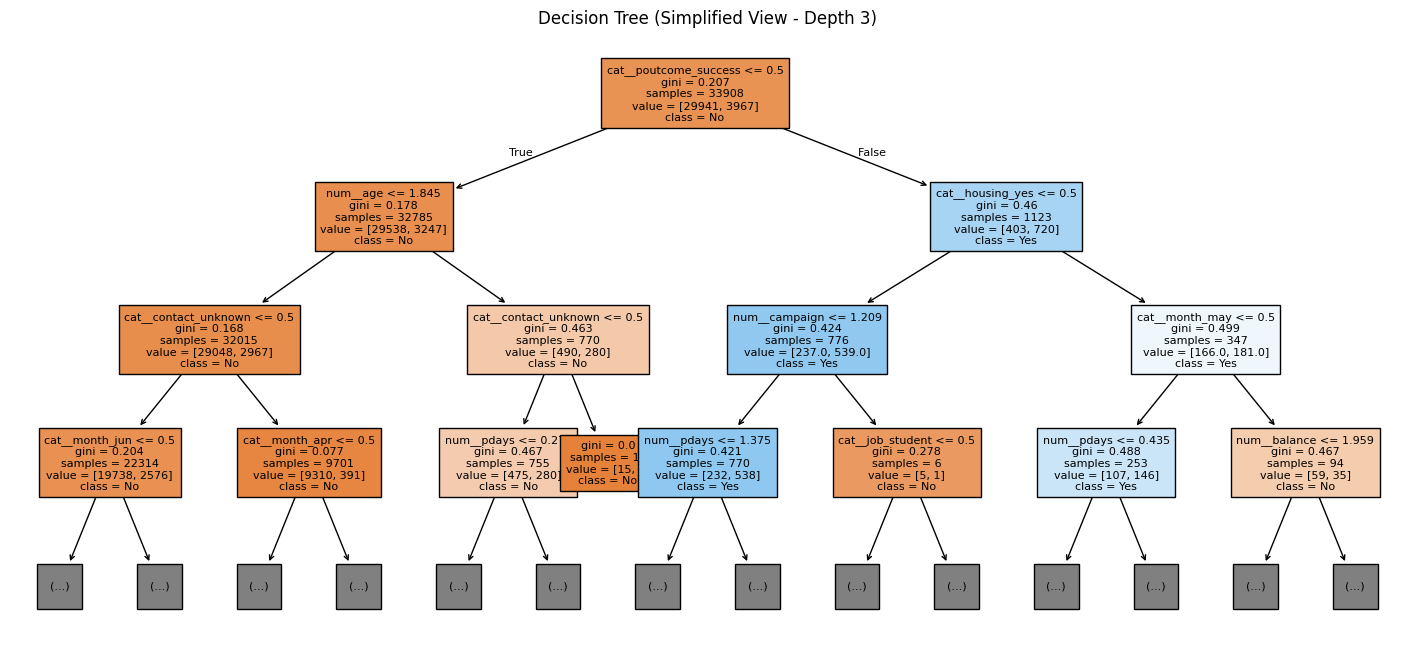

In [13]:
plt.figure(figsize=(18,8))
tree.plot_tree(
    tree_model,
    filled=True,
    feature_names=preprocessor.get_feature_names_out(),
    class_names=['No', 'Yes'],
    max_depth=3,  # limit depth for clarity
    fontsize=8
)
plt.title("Decision Tree (Simplified View - Depth 3)")
plt.show()


### ↠ Compare Model Performance
Logistic Regression reached an accuracy of 0.895, while the Decision Tree achieved 0.833.
The linear model performed better, suggesting that the relationship between the features and the target is mostly linear.
The Decision Tree captured more complex patterns but may have slightly overfitted the data, resulting in lower generalization on the test set.

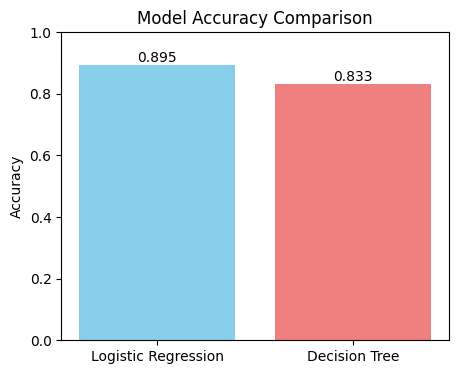

In [14]:
models = ['Logistic Regression', 'Decision Tree']
accuracies = [log_accuracy, tree_accuracy]

plt.figure(figsize=(5,4))
plt.bar(models, accuracies, color=['skyblue', 'lightcoral'])
plt.ylim(0, 1)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f"{acc:.3f}", ha='center')
plt.show()
